#  Classical causal discovery algorithms for cross-sectional data with causal-learn

In this notebook, we will use the [`causal-learn`](https://causal-learn.readthedocs.io/en/latest/) package, and apply several classical causal discovery approaches to the synthetic data `Synthetic_data.csv` generated with the previous notebook `Data_from_DAG.ipynb`. The dataset can be composed of variables of type continuous, discrete, binary, or text.

To execute this notebook, you will need to install two python packages, `causal-learn` and [`graphviz`](https://graphviz.org). The `causal-learn` package is required to be able to use the causal discovery algorithms, and `graphiz` package will be employed to visualize the output causal graphs.

In [1]:
%%capture
# Install python packages for causal discovery and graph visualization
!pip install causal-learn
!pip install graphviz

Let's begin by importing some basic python libraries to manage the data.

In [2]:
# Import basic python librairies
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import io
import matplotlib.image as mpimg

We will need to load the synthetic dataset, which has to be transformed into a `numpy ndarray` in order to be fed to the causal discovery algorithms.

In [3]:
data_file = "Synthetic_data.csv"
data = pd.read_csv(data_file)

# #If the Synthetic_data_inference.csv is used instead, than the boolean treatment variable has to be transformed to numeric
#data['v0'] = data['v0'].astype(int)

df = data.to_numpy()
labels = list(data)

print(data.head())

         X1        X2        X3        X4        X5        X6        X7
0  0.496714  1.399355  1.828552  1.637771  1.551422  1.595395  1.483987
1 -0.138264  0.924634  0.771918  0.685879  0.682759  0.640538  0.577445
2  0.647689  0.059630  0.628077  0.586716  0.588518  0.407152  0.312946
3  1.523030 -0.646937  0.845297  1.034066  1.081329  1.001057  0.946257
4 -0.234153  0.698223  0.274708  0.330364  0.193678  0.403647  0.382232


Now, we will test several classical causal discovery methods. Among constraint-based methods, we will test Peter and Clark’s (PC) and the Fast Causal Inference (FCI) algorithms. We will also test two LiNGAM-based functional causal methods: ICA-LiNGAM and Direct-LiNGAM. Among score-based algorithms, we will test Greedy Equivalence Search (GES).  For each method, we will import the required python library from `causal-learn` package.

# Constraint-based methods:

<font size="5">Peter and Clark’s (PC):</font>

Let's begin by running the causal discovery algorithm *PC* to data `df`. In `causal-learn`, several parameters can be customized:

**Input:**
* `data`: data should be in a `numpy.ndarray` type with shape `(n_samples,n_variables)`.
* `alpha`: a float number, $\alpha\in [0,1]$, used to define the desired significance of the independence test level. By default: `alpha=0.05`.
* `indep_test`: denotes the conditional independence test function. Several functions are available: Fisher's Z, Chi-squared, G-squared or kernel-based conditional independence test. By default, `indep_test=fisherz`.
* `stable`: a booleen variable to indicate to the algorithm to run a stabilized skeleton. By default: `stable= True`.
* `uc_rule`: it indicates how unshielded colliders will be oriented. By defaults: `uc_rule=0`.
* `uc_priority`: it defines how conflicts between unshielded colliders are solved, *i.e.* conflicts which arise when the confounders are not necessarily adjacent. By default `uc_priority=2`, *i.e.* existing colliders are prioritized.
* `verbose`: a boolean parameter generally used to request to print detailed logging information during the process. By default: `verbose=False`.
* `show_progress`: if we want to enable the visibility of the process, we can chose `True`, otherwise, we can hide it `show_progress=False`. By default: `show_progress=True`.
 
**Output:** `cg` a `CausalGraph` object that defines the output causal graph. Let's denote `cg.graph` by $G$: $G[i,j]$ denotes the causal link between variables $X_i$ and $X_j$ where $i,j \in \{1,\dots,n_\text{variables}\}$. Causal links can be identified as follows:
* $G[j,i]=1$ and $G[i,j]=-1$ means that variable $X_i$ causes variable  $X_j$ and is represented in the graph by $X_i \rightarrow X_j$
* $G[j,i] = G[i,j]=-1$ indicates the presence of an edge between $X_i$ and $X_j$, yet the edge orientation remains unknown. This relation is represented in the graph by $X_i - X_j$
* $G[j,i] = G[i,j]=1$ denotes the presence of an unobserved confounder between the linked variables and is represented in the graph by $X_i \leftrightarrow X_j$

To run *PC* algorithm with default parameters, we only need to specify the data.

In [4]:
from causallearn.search.ConstraintBased.PC import pc

cg1= pc(data=df)
print(cg1)

  0%|          | 0/7 [00:00<?, ?it/s]

To draw and visualize the graph, we need to use [`pydot`](https://pypi.org/project/pydot/) library.

In [5]:
%%capture
!pip install pydot

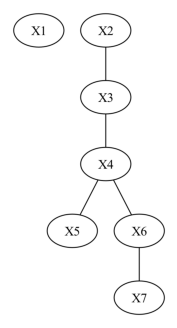

In [6]:
plt.figure(figsize=(4,4))
cg1.draw_pydot_graph(labels=labels)

As result, we obtain a graph where all relations are identified except the relation between $X_1$ and $X_2$. However, *PC* with default parameters fails to identify the causal directions. We can also save the resulted causal graph in a `.png` image format using the `GraphUtils` function.

In [7]:
from causallearn.utils.GraphUtils import GraphUtils
pyd = GraphUtils.to_pydot(cg1.G,labels=labels)
pyd.write_png('DAG_PC_Standard.png')

Now, let's modify the independence test for *PC* to see if the directions of the edges can be identified. For instance, let's take kernel-based conditional independence test, denoted by `kci`. We can choose the kernel function among Gaussian, Linear and Polynomial. We will test the Gaussian kernel. For ease of interpretation of the results, we will hide the algorithm progress *i.e.* we will give to the parameter `show_progress` the value `False`. As done previousely, we will plot the causal graph, hence save it (optionnal step).

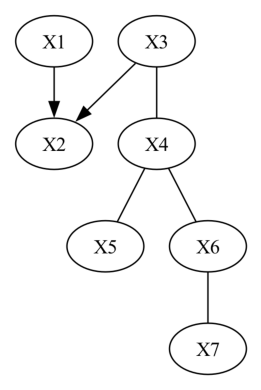

In [8]:
from causallearn.utils.cit import kci

cg2= pc(data=df, indep_test=kci,kernelZ='Gaussian',show_progress=False)

# visualization using pydot
plt.figure(figsize=(4,4))
cg2.draw_pydot_graph(labels=labels)

# Create and save the causal graph
pyd = GraphUtils.to_pydot(cg2.G,labels=labels)
pyd.write_png('DAG_PC_Kci_Gaussian.png')

We can alternatively plot the causal graph using another method based on `io` package.

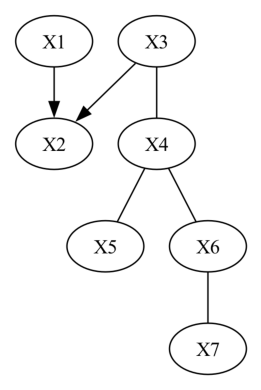

In [9]:
# visualize the causal graph
pyd = GraphUtils.to_pydot(cg2.G,labels=labels)
plt.figure(figsize=(4,4))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)

Regarding the obtained causal graph, the use of kernel based conditional independence test function with a Gaussian kernel instead of Fisher's Z function, taken by default, allows to discover a relationship between $X_2$ and $X_3$. However, the causal direction is inverted. Furthermore, most edge orientations are still missing.

You can also try a Polynomial Kernel, using `kernelZ='Polynomial'`. 

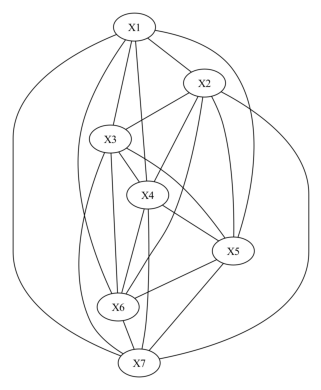

In [10]:
cg3= pc(data=df, indep_test=kci,kernelZ='Polynomial',show_progress=False)

# visualization using pydot
plt.figure(figsize=(4,4))
cg3.draw_pydot_graph(labels=labels)

# # Create and visualize the causal graph
# pyd = GraphUtils.to_pydot(cg3.G)
# pyd.write_png('DAG_PC_Kci_Polynomial.png')

In this case we obtain a complete undirected graph, suggesting that the choice done for the kernel is not well adapted for our data.

<font size="5">Fast Causal Inference (FCI):</font> 

Now, let's move to a second constraint-based causal discovery algorithm: Fast Causal Inference *FCI*. Like *PC*, many parameters can be adjusted according to the available dataset: 

**Input:**
* `dataset`: `numpy.ndarray` providing the data.
* `alpha`, `verbose`, `show_progress`: same as for *PC*.
* `max_path_length`

**Output:** *FCI* generates two outputs:
* `cg`: A `GeneralGraph` object where several causal links between variables can be found. Let's denote `cg.graph` by $G$:
  * $G[X_i,X_j] =-1$ and $G[X_j,X_i] =1$ means $X_i$ causes $X_j$, $X_i \rightarrow X_j$
  * $G[X_i,X_j] =2$ and $G[X_j,X_i] =1$ means $X_j$ is not an ancestor of $X_i$, $X_i \,\textrm{o}\!\!\rightarrow X_j$
  * $G[X_i,X_j] = G[X_j,X_i]= 2$ means absence of a d-separation set between $X_i$ and $X_j$, $X_i \,\textrm{o}\!\!-\!\!\textrm{o} X_j$
  * $G[X_i,X_j] = G[X_j,X_i]= 1$ indicates the presence of a common confounder for $X_i$ and $X_j$. In the graph, we represent the link by $X_i \leftrightarrow X_j$
* `edges`: defines the properties of the graph edges.

Let's run FCI with default parameters on the synthetic generated data. 

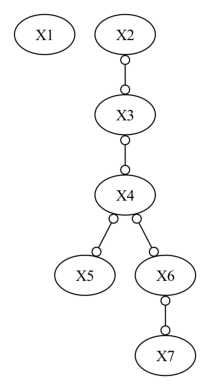

In [11]:
from causallearn.search.ConstraintBased.FCI import fci

cg4, edges4 = fci(dataset=df,show_progress=False)

# visualize the causal graph
pyd = GraphUtils.to_pydot(cg4,labels=labels)
plt.figure(figsize=(4,4))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)

# # save the causal graph
# pyd.write_png('DAG_FCI_Standard.png')

Like *PC*, *FCI* identifies the majority of links but fail in the edge orientation phase: of note, *FCI* clearly
highlights its doubts in edge direction using the dot arrowhead.

The independence test function can be modified through the parameter `indep_test` as previousely done with *PC* algorithm.

In [12]:
print("Run FCI with kernel - based conditional independence test and Gaussian Kernel")
cg5, edges5 = fci(dataset=df, indep_test=kci,kernelZ='Gaussian',show_progress=False)

Run FCI with kernel - based conditional independence test and Gaussian Kernel


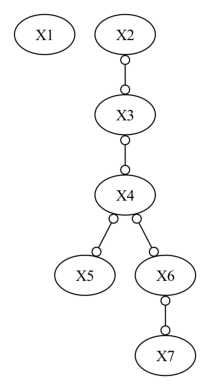

In [13]:
pyd = GraphUtils.to_pydot(cg5, labels=labels)
plt.figure(figsize=(4,4))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)

# # save the causal graph
# pyd.write_png('DAG_FCI_Kci_Gaussian.png')

# Functional constraint-based methods

Now, we will move to causal discovery algorithms based on functional causal models, in particular, the Linear non-Gaussian acyclic model *LiNGAM*.

<font size="5">ICA-LiNGAM:</font> 

**Input**: 
* `data` a numpy array data type. 
* `random_state`: to fix a seed in order to maintain reproducibility of obtained results.
* `max_iter`: an integer to precise the maximum number of iterations of FastICA. By default: `max_iter=1000`.
 
**Output:** 
* `model.causal_order_`: an array of shape `n_variables`. It denotes the causal order of the fitted model
* `model.adjacency_matrix_`: designs the adjacency matrix $B$ of the fitted model. It is a squared matrix of size `(n_variables, n_varaibles)` and contains the coefficient $b_{ij}$ governing the linear relationships between variables, $X_i=\sum_{j}b_{ji}X_j+U_i$, following LiNGAM hypotheses.

In [14]:
from causallearn.search.FCMBased import lingam

# A. Run ICA-LiNGAM with defaults parameters
model = lingam.ICALiNGAM(random_state=42)
model.fit(df)

print(model.adjacency_matrix_)

/Users/ibalelli/miniconda/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[[ 0.          0.          0.          0.48482815  0.          0.
   0.        ]
 [-0.99384325  0.          0.9913067   0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.99643504  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.99769506  0.          0.
   0.        ]
 [ 0.          0.          0.          1.00108966  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.99818022
   0.        ]]


For LiNGAM-based methods form `causal-learn` there is not a direct way to convert the output into a graph: we need to define a custom function that take as inputs the model's adjacency matrix and generate the graph:

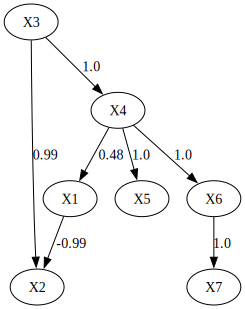

In [15]:
def make_graph(name, adjacency_matrix, labels = None, edge_label = True):
    """make_graph generate a graph from a (weighted) adjacency matrix, using graphviz.

    * name (str): name of the generated graph
    * adjacency_matrix (numpy 2D array): squared (weighted) adjacency matrix
    * labels (list of str): variables name (ordered as in the adjacency_matrix)
    * edge_label (boolean): if edge_label==True the b_ij values will be printed on the corresponding edge
    
    return the digraph
    """
    
    graph = graphviz.Digraph(name)

    n_vars = len(adjacency_matrix)
    if labels is None: labels = ['X'+str(i) for i in range(len(n_vars))]
    
    # Add nodes
    for node in labels:
        graph.node(node)
    # Add edges
    for i, j in np.ndindex((n_vars,n_vars)):
        if adjacency_matrix[i,j]!=0:
            graph.edge(labels[j], labels[i],label=str(round(adjacency_matrix[i,j],2))) if edge_label == True else graph.edge(labels[j], labels[i])
    return graph

output_graph = make_graph('DAG_ICALiNGAM_Default', model.adjacency_matrix_, labels)
output_graph

The `output_graph` can be saved using the `render` method from `graphviz`.

In [16]:
# Save the graph
output_graph.render()

'DAG_ICALiNGAM_Default.gv.pdf'

Alternatively, one can rely on the [`lingam`](https://lingam.readthedocs.io/en/latest/index.html) package, a `Python` package specifically dedicated to the lingam-based methods, which provides in particular a way to generate the graph, from a (weighted) adjacency matrix.

In [17]:
%%capture
!pip install lingam

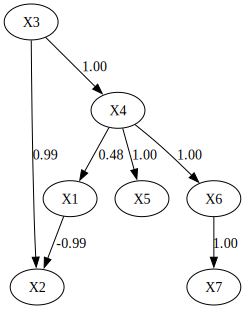

In [18]:
import lingam
from lingam.utils import make_dot
make_dot(model.adjacency_matrix_,labels=labels)

<font size="5">Direct-LiNGAM:</font> 

Now, we will test the second LiNGAM-based method: the *DirectLiNGAM*. Firstly, we will run the method without any prior knowledge about the variables links. To do this, we only need to call the method from lingam class.

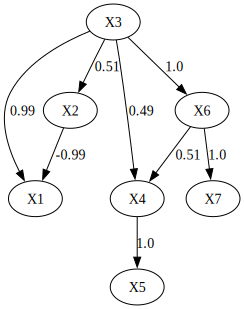

In [19]:
from causallearn.search.FCMBased import lingam

# B1. Run Direct-LiNGAM with defaults parameters
model = lingam.DirectLiNGAM()
model.fit(df)
G= make_graph('DAG_DirectLiNGAM_Default',model.adjacency_matrix_, labels)
G

As presented in the chapter, we can integrate expert prior knowledge to the Direct-LiNGAM causal method. This is done by providing a matrix `M` of size `(n_variables,n_variables)` which should be structured as follows:
* `M[j,i]=0` if $X_i\nrightarrow X_j$
* `M[j,i]=1` if $X_i\rightarrow X_j$
* `M[j,i]=-1` if no prior is available concenring the relationship from $X_i$ to $X_j$

We can define a function to generate this matrix by hand:

In [20]:
def make_prior(n_vars, root=None, sink=None, true_edg=None, miss_edg=None):
    """make_prior generate a (n_vars,n_vars) matrix with prior information
    that can be passed to causal-learn lingam based models (if prior knowledge is supported).

    * n_vars (int): number of variables
    * root (int or list of int): indexes of root variables
    * sink (int or list of int): indexes of sink variables
    * true_edg (list of lists): list containing 2 elements'lists of related variables
    * miss_edg (list of lists): list containing 2 elements'lists of non-related variables
    
    return the prior matrix
    """

    if type(root) == int: root = [root]
    if type(sink) == int: sink = [sink]
        
    M=-np.ones(shape=(n_vars,n_vars),dtype=int)

    for i, j in np.ndindex((n_vars,n_vars)):
        if ((sink is not None) and (i in sink) and (j!=i)):
            M[j,i]=0
        elif ((root is not None) and (i in root) and (j!=i)):
            M[i,j]=0
        elif ((true_edg is not None) and ([i,j] in true_edg)):
            M[j,i]=1
        elif ((miss_edg is not None) and ([i,j] in miss_edg)):
            M[j,i]=0

    return M
    
M = make_prior(n_vars=7,root=[0,1],sink=6)
print('Prior knowledge matrix is:')
print(M)

Prior knowledge matrix is:
[[-1  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0]
 [-1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1 -1 -1]]


Of note, the `lingam` package provides as well a function to build the prior knowledge matrix, `make_prior_knowledge`.

Therefore, the causal discovery method with domain expert prior knowledge can be runned, by passing the matrix `M` through the parameter `prior_knowledge`.

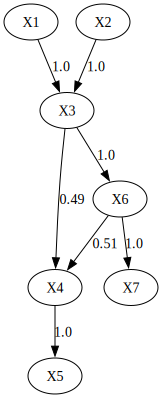

In [21]:
# B2. Run Direct-LiNGAM with prior knowledge

model = lingam.DirectLiNGAM(prior_knowledge=M)
model.fit(df)
G= make_graph('DAG_DirectLiNGAM_withPriorKnowledge',model.adjacency_matrix_, labels)
G

# Score-based methods:

<font size="5">Greedy Equivalence Search (GES):</font> 

*GES* searches among possible graphs the one that best fits the data: it uses a score to evaluate the trade-off between the model complexity and fitting quality to the data. In `causal-learn`, the default score for *GES* is the Bayesian Information Criterion *BIC*. To run *GES*, with default parameters we only need to call the algorithm and apply it on the data. 

In [22]:
from causallearn.search.ScoreBased.GES import ges

cg6 = ges(df)['G']

Then we can visualize and save the graph as previousely done. 

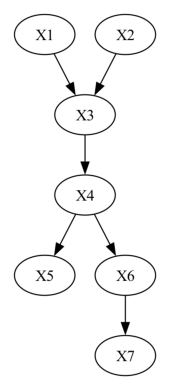

In [23]:
# visualize the causal graph
pyd = GraphUtils.to_pydot(cg6,labels=labels)
plt.figure(figsize=(4,4))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)

# save the graph
pyd = GraphUtils.to_pydot(cg6)
pyd.write_png('DAG_GES_Standard.png')

We can observe that *GES* identifies correctly the ground truth graph. 

If we want to modify the likelihood score, we can specify it in the parameter `score_function`. In `causal-learn`, several scores are implemented such as: BDeu score, Generalized score with cross validation or with marginal likelihood. Let's test for instance the negative k-fold cross-validated log likelihood score. 

GES with negative k-fold cross-validated log likelihood score


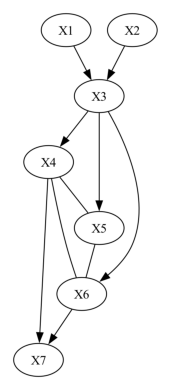

In [24]:
print('GES with negative k-fold cross-validated log likelihood score')
cg7 = ges(df,score_func ='local_score_CV_general')['G']

# visualize the causal graph
pyd = GraphUtils.to_pydot(cg7,labels=labels)
plt.figure(figsize=(4,4))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)

# save the graph
pyd = GraphUtils.to_pydot(cg7)
pyd.write_png('DAG_GES_local_score_CV_general.png')

We observe that some directions are not well identified such as $X_4$ to $X_5$ and $X_4$ to $X_6$. In addition, some unexistant links are found. 